# isnalyser
This notebook will allow users to experiment with more parameters as those provided in the pypi package.


### Importing the necessary libraries

In [ ]:
from collections import defaultdict
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from graphviz import Digraph

### Creating the dataframe from the files

In [ ]:
path_to_transmitters_file = 'https://raw.githubusercontent.com/dhakarat/isnalyser/master/isnalyser/example_data/transmitters_example.csv'
path_to_transmissions_file = 'https://raw.githubusercontent.com/dhakarat/isnalyser/master/isnalyser/example_data/transmissions_example.csv'

In [ ]:
df_nodes = pd.read_csv(path_to_transmitters_file)
df_edges = pd.read_csv(path_to_transmissions_file)

### Abbreviation

In [ ]:
# The following dictionary contains some possible abbreviation and can be edited or complemented according to the needs
d_abb = {'Muḥammad': 'M.', 
         'Abd al-Raḥmān': 'AR', 
         'Abd Allāh': 'AA', 
         'ibn':'\n b.'}

In [ ]:
def abbreviates(string, dic):
    """Create an abbreviated version of all transmitters' name according to the given dictionary.
    """
    new_str = string
    for key in dic:
        new_str = new_str.replace(key, dic[key])
    
    return new_str

In [ ]:
# Modifying the dataframes
df_nodes['Transmitters'] = df_nodes.Transmitters.apply(abbreviates, dic=d_abb)
df_edges['From'] = df_edges.From.apply(abbreviates, dic=d_abb)
df_edges['To'] = df_edges.To.apply(abbreviates, dic=d_abb)

### Ranking the transmitters chronologically

In [ ]:
timeline_step = 15 # defining the time laps between each time step, default 15 years
df_nodes['Ranking'] = df_nodes.dAH // timeline_step

### Functions and parameters for the timeline subgraph

In [ ]:
def rank_list(date:str, rank:int, df:pd.DataFrame.astype) -> list:
    """
    Return a list with the date and all the node 
    ids that should be placed at the same rank.
    """
    same_rank = df[df.Ranking==rank].Transmitters.values
    l = [date]
    if len(same_rank) == 0:
        same_rank = ['placeholder']
    l.extend(same_rank)

    return l

In [ ]:
def same_rank_subgraph(G:Digraph, rank_lst:list) -> None:
    """ Return a subgraph of nodes from same-rank ids. """
    with G.subgraph() as s:
        s.attr(rank='same')
        for node_id in rank_lst:
            if node_id != 'placeholder':
                s.node(node_id)

In [ ]:
def a_timeline(G:Digraph, minimum:int, maximum:int, step:int, n_attr:dict, e_attr:dict) -> None:
    """
    Create a timeline in the form of a subgraph
    G = the original graph
    s = G's subgraph
    minimum = start of the timeline
    maximum = end of the timeline
    step = years' slice
    n_attr = dict with the attribute of the subgraph's nodes
    e_attr = dict with the attribute of the subgraph's edges
    """
    with G.subgraph(name='cluster') as s:
        s.attr(color='white', K='0.3')
        for j in range(minimum, maximum, step):
            s.node_attr.update(**n_attr)  
            s.edge(str(j), str(j+step), **e_attr)

### Concentrating the paths to avoid multiple edges

In [ ]:
def path_all(df):
    """Join the edges that start and end with the same transmitters."""
    return '\n'.join(df.FileName)


def merge_edges(df:pd.DataFrame.astype) -> pd.DataFrame.astype:
    """ 
    Merge redundant edges into a single edge connecting nodes.
    If file doesn't provide FileName (i.e. name of text), return input dataframe.
    """
    try:
        df_paths = df.merge(
                            pd.DataFrame(df.groupby(['From', 'To']).apply(path_all)),
                            on=['From', 'To']).rename(columns={0:'paths'})
        return df_paths[~df_paths.duplicated(['From', 'To'])]
    except AttributeError:
        return df


df_edges = merge_edges(df_edges)

### Function and parameters to colour the transmitters according to their place of origin

In [ ]:
""" This module uses a list of colours, called <colors>, the length of which = the number of cities that need to be highlighted in different colours.
    With a for loop it then creates a dictionary and attributes to each city [key] a color [value]
    
"""

def get_discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap based on the specified input map. """
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    
    return base.from_list(cmap_name, color_list, N)

### Drawing the graph

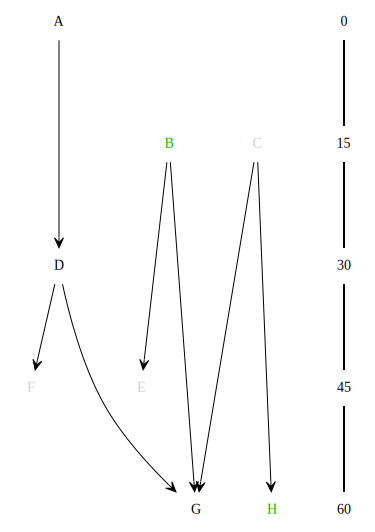

In [ ]:
# Creating the main graph    
g = Digraph('graph', filename='graph.gv',
            graph_attr=dict(size='12,24', fontsize='16',
            ranksep='1.2', concentrate='false'),
            node_attr=dict(shape='none')) 

# coloring the nodes according to origin
color_origin='auto'
num_origins = df_nodes.Origin.nunique(dropna=False)
if color_origin=='auto':
    cmap = get_discrete_cmap(num_origins, base_cmap='nipy_spectral')
    colors = (mpl.colors.to_hex(cmap(i)) for i in range(num_origins))
    color_cycle = itertools.cycle(colors)
    # Matching colors to origins
    color_origin = dict()
    for i, origin in enumerate(df_nodes.Origin.unique()):
      color_origin[origin] = next(color_cycle)
else:
    # every origin black except those in the color_origin parameter
    color_origin = defaultdict(lambda: 'black', color_origin)

df_nodes['Color'] = df_nodes.Origin.map(color_origin)
        
# Creating the nodes
for _, row in df_nodes.iterrows():
    g.node(name=row.Transmitters, fontcolor=row.Color)

# Defining the timeline subgraph attributes
minimum = df_nodes.Ranking.min()
maximum = df_nodes.Ranking.max()

#Dictionary of nodes' attributes
n_attr = {'name':'j', 'shape':'none'}

#Dictionary of edges' attributes
e_attr = {'arrowhead':'none', 'color':'black', 'penwidth':'2', 'len':'1.0'}

# Creating the timeline as a subgraph
a_timeline(g, minimum*timeline_step, maximum*timeline_step, timeline_step, n_attr, e_attr)

#  Linking the nodes of the subgraph and the main graph together
for rank in range(df_nodes.Ranking.unique().max()+1):
    nodes_ranks = rank_list(str(rank*timeline_step), rank, df_nodes)
    same_rank_subgraph(g, nodes_ranks)

# Creating the edges (transmission paths)
for _, row in df_edges.iterrows():
    g.edge(row.From, row.To, arrowhead='vee')

g.format= 'svg' # 'pdf'

g.view()
g